# German Traffic Sign Recognition
## w281 Computer Vision
### Final Project


In [183]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

import keras  
import os
import glob 
from skimage import io 
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

from scipy import ndimage
from scipy.ndimage.filters import convolve
from scipy import misc

import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker
from tqdm import tqdm
from PIL import Image
from timeit import itertools

import copy
import imagesize

from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [2]:
# The standard image size for VGG16 and VGG19 Resnet is 224 x 224
STD_IMG_SIZE = (224, 224)

RED = 0
GREEN = 1
BLUE = 2

dataset_path = './sign_data/'

In [3]:
# Class to Load Dataset of Train and Test
# Meta.csv contains an additional column with a label description for the class

class DataLoad:
    def __init__(self, path):
        self.path = path
        self.class_data = None
        self.train_meta = None
        self.train_data = []
        self.test_meta = None
        self.test_data = []
        
    def load_meta(self):
        # Read meta data file into a dataframe and order by ClassId
        self.class_data = pd.read_csv(self.path + 'Meta_full.csv')
        self.class_data = self.class_data.sort_values(by=['ClassId'])
        
        # Get number of classes (number of rows)
        self.class_rows = self.class_data.shape[0]
        
    def display_meta(self):
        # Display images from Meta directory in a 6x8 array
        if self.class_data is not None:
            fig, ax = plt.subplots(nrows=9, ncols=5, figsize=(11, 11))
            # double space the rows
            fig.subplots_adjust(hspace=1)
            c = 0
            for r, (file, title) in enumerate(zip(self.class_data['Path'], self.class_data['Description'])):
                ax[r//5, c%5].imshow(plt.imread(self.path + file))
                ax[r//5, c%5].axis('off')
                ax[r//5, c%5].set_title(f'Class {r}'+'\n'+ title, fontsize=7)
                c += 1
            # delete the last two axes
            fig.delaxes(ax[8,3])
            fig.delaxes(ax[8,4])
            plt.show()

    def load_train(self, remove=True):
        self.__load_data(train=True, remove=True)

    def load_test(self, remove=True):
        self.__load_data(train=False, remove=True)

        
    def __load_data(self, train=True, remove=True):
        data_file = 'Train.csv' if train is True else 'Test.csv'
        print(data_file)
            
        # Read csv file and sort by Class Id
        _oDF = pd.read_csv(self.path + data_file)
        _oDF = _oDF.sort_values(by=['ClassId'])
        
        # Remove duplicated rows
        if (remove is True):
            _oDF.drop_duplicates(['Path'])
        
        # Create a comprehensive list of images
        _data_list = [(self.path + i_path, cl) for i_path, cl in zip(_oDF['Path'], _oDF['ClassId'])]
        
        # Get number of images
        _rows = _oDF.shape[0]
        
        if train is True:
            self.train_meta = _oDF.copy()
            self.train_data = copy.deepcopy(_data_list)
            self.train_rows = _rows
        else:
            self.test_meta = _oDF.copy()
            self.test_data = copy.deepcopy(_data_list)
            self.test_rows = _rows
        
    def display_train(self):
        # Display a random set of train images (1 per class)
        if self.train_meta is not None:
            self.__display_random_data(train=True)
        
    def display_test(self):
        # Display a random set of test images (1 per class)
        if self.test_meta is not None:
            self.__display_random_data(train=False)
        
    def __display_random_data(self, train=True):
        _oDF = self.train_meta if train is True else self.test_meta
        
        # Get random samples
        images = []
        for i in range(self.class_rows):
            images.append(_oDF[_oDF['ClassId'] == i].sample()['Path'].values.astype(str)[0])

        # Create a 6 x 8 plot matrix
        fig, ax = plt.subplots(nrows=6, ncols=8, figsize=(11, 11))
        c = 0
        for r, file in enumerate(images):
            ax[r//8, c%8].imshow(plt.imread(self.path + file))
            ax[r//8, c%8].axis('off')
            ax[r//8, c%8].set_title(f'Class {r}', fontsize=8)
            c += 1
        for i in range(r, 48):
            ax[5,i%8].axis('off')
        plt.show()
        
        
    def display_train_test_distribution(self):
        if (self.train_meta is not None) and (self.test_meta is not None):
            # Lisa's code
            # ------------------------------------------------------------
            # show the train and test class ids in two separate bar graphs

            # Homologate vars:
            train_class_id = [img[1] for img in self.train_data]
            test_class_id = [img[1] for img in self.test_data]
            
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.bar(np.unique(train_class_id), np.bincount(train_class_id))
            plt.title("Distribution of Train Classes")
            plt.subplot(1, 2, 2)
            plt.bar(np.unique(test_class_id), np.bincount(test_class_id))
            plt.title("Distribution of Test Classes")

        
    def display_distribution(self, train=True):
        if (self.train_meta is not None and train is True) or (self.test_meta is not None and train is False):
            fig, axs = plt.subplots(1, 1, figsize =(10, 5), tight_layout=True)

            # Remove axes splines 
            for s in ['top', 'bottom', 'left', 'right']: 
                axs.spines[s].set_visible(False) 

            # Add padding between axes and labels 
            axs.xaxis.set_tick_params(pad = 5) 
            axs.yaxis.set_tick_params(pad = 5)

            axs.set_xticks(range(self.class_rows))

            # Add x, y gridlines 
            axs.grid(color ='grey', 
                    linestyle ='-.', linewidth = 0.5, 
                    alpha = 0.5)

            # Create histogram
            if train is True:
                data = self.train_meta['ClassId']
                titl = 'Distribution of Train Classes'
            else:
                data = self.test_meta['ClassId']
                titl = 'Distribution of Test Classes'

            N, bins, patches = axs.hist(data, bins=self.class_rows)

            # Setting color: darker means less images per class
            #                lighter color means more images per class
            fracs = ((N**(1/8)) / N.max())
            norm = colors.Normalize(fracs.min(), fracs.max())

            # Use magma palette color
            for thisfrac, thispatch in zip(fracs, patches):
                color = plt.cm.magma(norm(thisfrac))
                thispatch.set_facecolor(color)

            # Adding extra features and Title 
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title(titl)

            # Rotate class label (x-axis) for better visualization
            plt.xticks(fontsize=9, rotation=60)
            plt.yticks(fontsize=10, rotation=0)

            # Show plot
            plt.show()
            
    def get_image_size(self, train=True):
        # Faster approach to get image size w/o loading file in memory
        if (self.train_meta is not None and train is True):
            _data_list = self.train_data
        elif (self.test_meta is not None and train is False):
            _data_list = self.test_data
            
        train_image_size = []
        for i in tqdm(range(len(self.train_data))):
            train_image_size.append(imagesize.get(self.train_data[i][0]))
            
        return (min(train_image_size), max(train_image_size))

            
    def image_size(self):
        if (self.train_meta is not None) and (self.test_meta is not None):
            # Lisa's code
            # ------------------------------------------------------------
            # show the train and test class ids in two separate bar graphs

            # Homologate vars:
            train_image_path = [img[0] for img in self.train_data]
            test_image_path = [img[0] for img in self.test_data]
        
            # get the minimum and maximum size of the images in the train and test data
            train_image_size = []
            for i in tqdm(range(len(train_image_path))):
                train_image_size.append(Image.open(train_image_path[i]).size)
            print("Minimum size of train image: ", min(train_image_size))
            print("Maximum size of train image: ", max(train_image_size))

            test_image_size = []
            for i in tqdm(range(len(test_image_path))):
                test_image_size.append(Image.open(test_image_path[i]).size)
            print("Minimum size of test image: ", min(test_image_size))
            print("Maximum size of test image: ", max(test_image_size))

In [4]:
# Create Data Instance
dl = DataLoad(dataset_path)

In [5]:
# Load Meta Info
dl.load_meta()
dl.class_data.sample(10)

,Path,ClassId,ShapeId,ColorId,SignId,Description
30,Meta/36.png,36,1,1,4.4,Ahead or turn right only
25,Meta/31.png,31,0,0,1.36,Wild animal crossing
2,Meta/1.png,1,1,0,3.29,Max limit (30 km/h)
33,Meta/39.png,39,1,1,4.8,Pass by on left
22,Meta/29.png,29,0,0,1.34,Bicycle crossing
15,Meta/21.png,21,0,0,1.3.2,Double curve
27,Meta/33.png,33,1,1,4.2,Turn right ahead
20,Meta/26.png,26,0,0,1.24,Traffic signals ahead
16,Meta/22.png,22,0,0,1.1,Uneven road surface
26,Meta/32.png,32,1,3,3.42,End of all restrictions


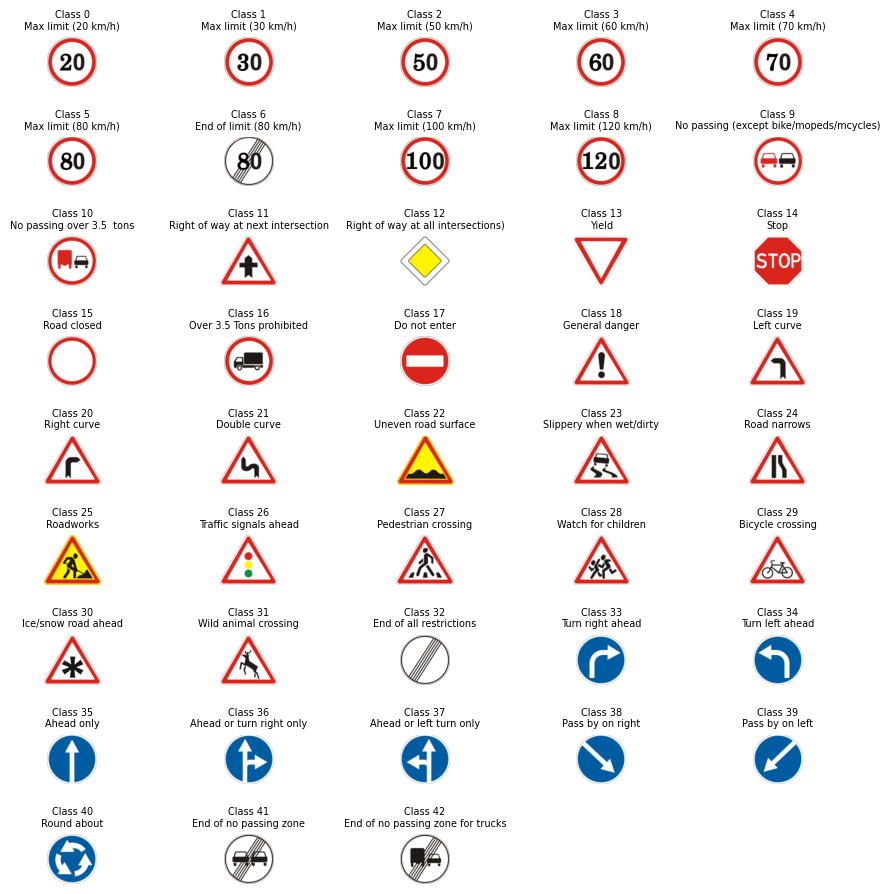

In [6]:
# Display meta images - This is optional
dl.display_meta()


In [7]:
# Load train data and sample some rows
dl.load_train()
dl.train_meta.sample(5)


Train.csv


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
34181,43,42,6,5,38,37,34,Train/34/00034_00013_00012.png
26398,143,132,12,12,130,121,18,Train/18/00018_00027_00028.png
37977,74,75,6,7,68,69,38,Train/38/00038_00065_00028.png
8289,33,34,5,6,28,29,4,Train/4/00004_00061_00009.png
12621,48,44,6,5,42,39,8,Train/8/00008_00015_00021.png


In [8]:
# Load test data and sample some rows
dl.load_test()
dl.test_meta.sample(5)


Test.csv


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
1902,36,35,6,6,31,30,31,Test/01902.png
10238,61,58,5,6,56,53,23,Test/10238.png
11512,35,33,6,5,30,28,20,Test/11512.png
12415,96,91,9,8,88,83,1,Test/12415.png
12485,67,64,6,6,61,59,13,Test/12485.png


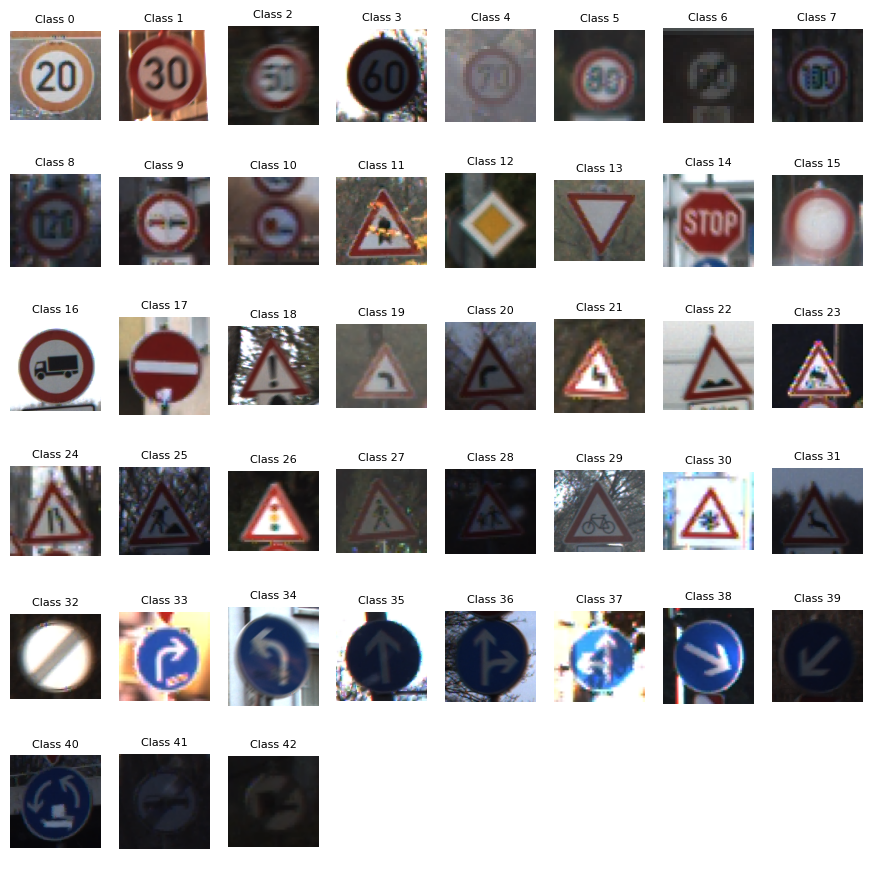

In [9]:
# Display a random selected image of each class from Train images
dl.display_train()

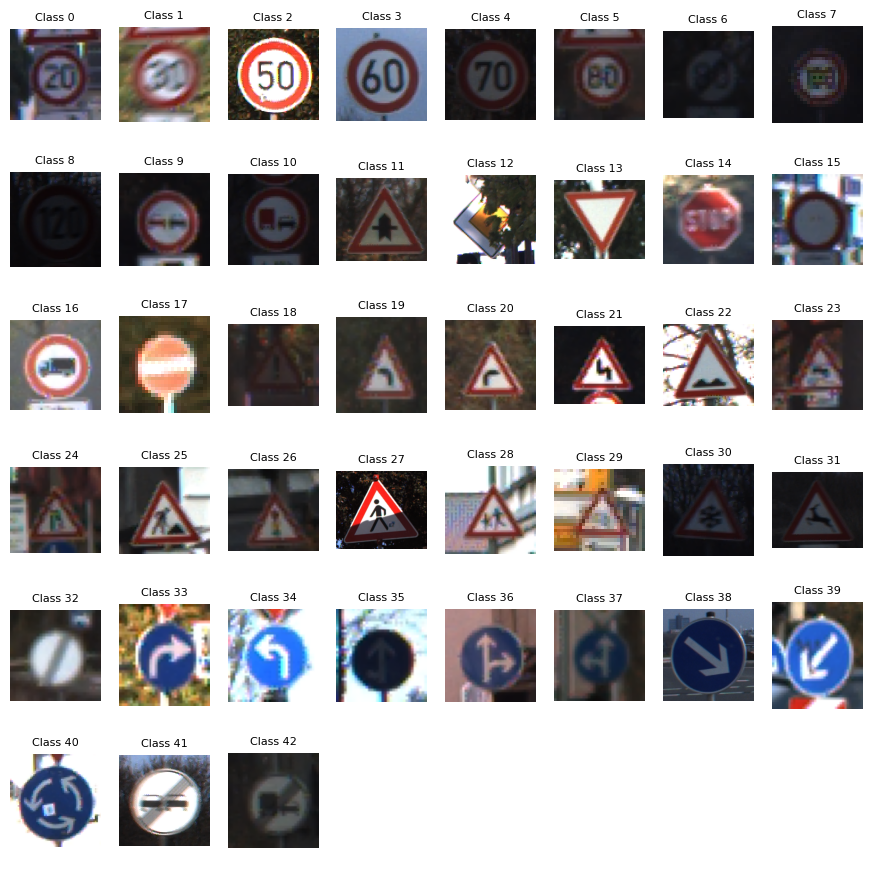

In [10]:
# Display a random selected image of each class from Test images
dl.display_test()

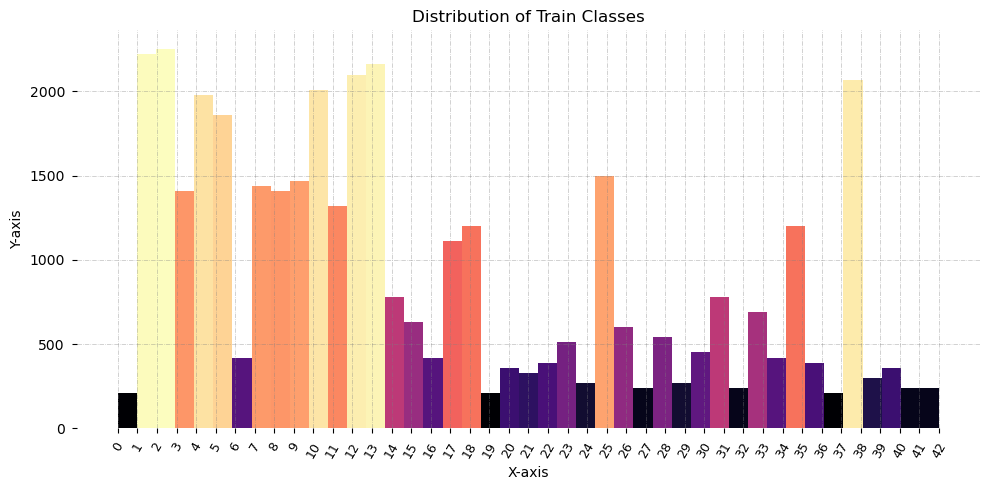

In [11]:
# Display class distribution of Train data
dl.display_distribution(train=True)


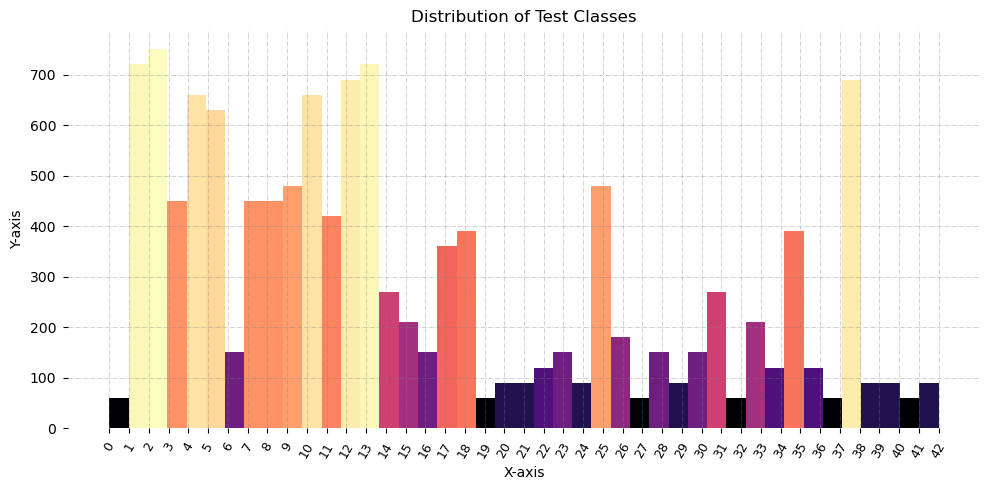

In [12]:
# Display class distribution of Test data
dl.display_distribution(train=False)


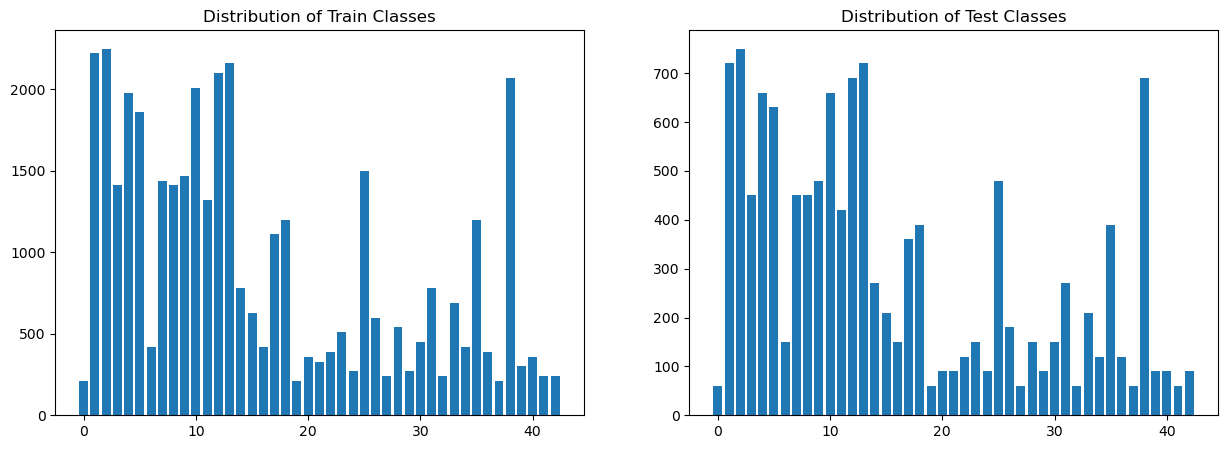

In [13]:
# Display a comparison class distribution between Train and Test
dl.display_train_test_distribution()

In [15]:
# Get Train image size
image_size = dl.get_image_size(train=True)
print(f'Min size of train image: {image_size[0]}')
print(f'Max size of train image: {image_size[1]}')


100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [00:06<00:00, 6051.32it/s]

Min size of train image: (25, 25)
Max size of train image: (243, 225)


In [16]:
# Get Test image size
image_size = dl.get_image_size(train=False)
print(f'Min size of train image: {image_size[0]}')
print(f'Max size of train image: {image_size[1]}')


100%|███████████████████████████████████████████████████████████████████████████| 39209/39209 [00:06<00:00, 6297.49it/s]

Min size of train image: (25, 25)
Max size of train image: (243, 225)


In [17]:
# Get number of images for both, Train and Test images dataset
print(f'Number of Train images: {dl.train_rows}')
print(f'Number of Test images: {dl.test_rows}')


Number of Train images: 39209
Number of Test images: 12630


## Image Preprocessing

In [18]:
# Class to preprocess images

class ImagePreproc:
    def __init__(self, odata):
        '''
        Class instanciation
        Input parameter: odata - Object of class DataLoad
        '''
        self.data = odata
        self.image = None
        self.PILimage = None
        
    def load_image(self, imgfile):
        # Returns a PIL format
        self.PILimage = load_img(imgfile)
        return self.PILimage
        
    def open_image(self, imgfile):
        # Returns a tensor of dtype='string'
        self.image = tf.io.read_file(imgfile)
        return self.image
        
    def decode_image(self, img=None, channels=3):
        img = self.image if img is None else img
        return tf.io.decode_image(img, channels=channels, dtype=tf.dtypes.float32)

    def resize_image(self, img=None, size=(32,32)):
        img = self.image if img is None else img
        return tf.image.resize(img, size=size)
        
    def bright_image(self, img=None, brightness=0.3):
        img = self.image if img is None else img
        return tf.image.adjust_brightness(img, brightness)
    
    def contrast_image(self, img=None, factor=3):
        img = self.image if img is None else img
        return tf.image.adjust_contrast(img, contrast_factor=factor)
    
    def flip_image(self, img=None):
        img = self.image if img is None else img
        return tf.image.flip_left_right(img)
    
    def display_image(self, img=None, title=''):
        img = self.PILimage if img is None else img
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        plt.show()

    def distortion_free_resize(self, image=None, img_size=(32, 32)):
        image = self.image if image is None else image
        w, h = STD_IMG_SIZE
        image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

        # Check tha amount of padding needed to be done.
        pad_height = h - tf.shape(image)[0]
        pad_width = w - tf.shape(image)[1]

        # add the same amount of padding on both sides.
        if pad_height % 2 != 0:
            height = pad_height // 2
            pad_height_top = height + 1
            pad_height_bottom = height
        else:
            pad_height_top = pad_height_bottom = pad_height // 2

        if pad_width % 2 != 0:
            width = pad_width // 2
            pad_width_left = width + 1
            pad_width_right = width
        else:
            pad_width_left = pad_width_right = pad_width // 2

        image = tf.pad(
            image,
            paddings=[
                [pad_height_top, pad_height_bottom],
                [pad_width_left, pad_width_right],
                [0, 0],
            ],
        )

        # To improve the model accuracy, use the following techniques to
        # adjust brightness, adjust contrast, transpose and flip the images
        image = tf.image.adjust_brightness(image, 0.3)
        image = tf.image.adjust_contrast(image, contrast_factor=3)
#         image = tf.transpose(image, perm=[1, 0, 2])
#         image = tf.image.flip_left_right(image)
        return image

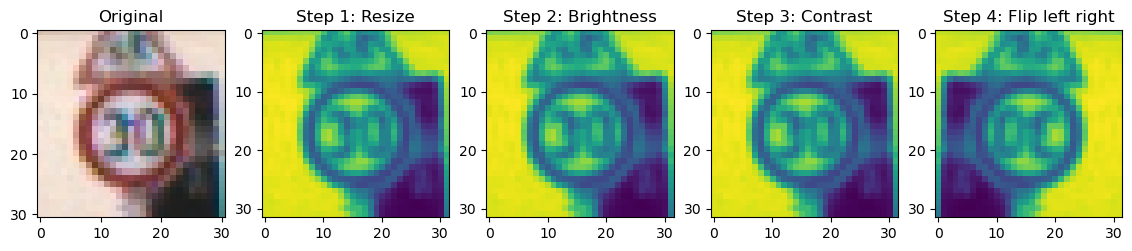

In [19]:
# use one example to explore the image transformation and augmentation techniques
#################################################################################

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# Create preproc train instance
pp = ImagePreproc(dl)

# pull first image from data
pp.load_image(pp.data.train_data[900][0])

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(pp.PILimage)
ax.set_title("Original", size=12)

# test the image transformation
img_io = pp.open_image(pp.data.train_data[900][0])

# 2. Decode and convert to grayscale
img_io = pp.decode_image(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
# img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = pp.resize_image(img_io, size=(32, 32))
ax.imshow(array_to_img(img_resize))
ax.set_title("Step 1: Resize", size=12)

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = pp.bright_image(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title("Step 2: Brightness", size=12)


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = pp.contrast_image(img_bright, factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title("Step 3: Contrast", size=12)


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = pp.flip_image(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title("Step 4: Flip left right", size=12);


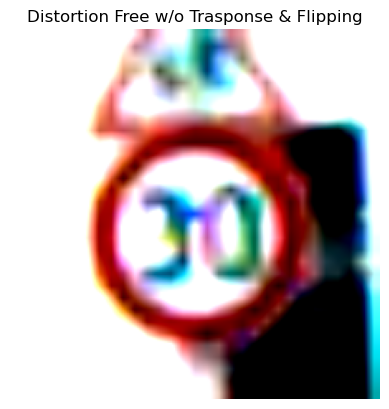

In [20]:
# Test distortion free

# img_io = pp.open_image(pp.data.train_data[900][0])
# img_io = pp.decode_image(img_io, channels=3)
img_io = pp.decode_image(pp.image, channels=3)

img_df = pp.distortion_free_resize(img_io)

pp.display_image((img_df*255).astype(np.uint8), title='Distortion Free w/o Trasponse & Flipping')


## Feature Extraction

In [24]:
# Class to detect edges
class EdgeDetector:
        '''
        Class instanciation
        Input parameter: imgs - Array of images
                         sigma - For gaussian filter
                         Kernel_size - For gaussian filter
                         weak_pixel - Low intensity value in image
                         stong_pixel - High intensity value in image
                         lowthreshold - Lower bound of threshold
                         highthreshold - Higher bound of threshold
        '''
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        return np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180

        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0

                except IndexError as e:
                    pass

        return Z

    def _threshold(self, img):
        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def _hysteresis(self, img):
        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self._threshold(self.nonMaxImg)
            img_final = self._hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final


In [242]:
# Class to match templates (Advanced Feature Extraction)
class TemplateMatching:
    def __init__(self, img=None, template=None, thresholdVal=-1):
        '''
        Class instanciation
        Input parameter: img - Original Image
                         template - Image template
                         thresholdVal - Pixels in the template with value greater that threshold are used
                                        -1 (default) to use all pixels or 0  to use edges with value > 0
        '''
        self.image = img
        self.template = template
        self.thresholdVal = thresholdVal
        self.maxima = 0
        self.minima = 0
        return
    
    def get_imageMaxMin(self, img=None):   
        img = self.image if img is None else img
        return np.amax(img), np.amin(img)

    def open_image(self, imgfile):   
        inputImage = Image.open(imgfile)
        width, height = inputImage.size

        inputArray = np.array(inputImage)
        outputArray = np.zeros((height, width), dtype='uint8')

        # Combine pixel values, for each row and column
        for y in range(0, height):
            for x in range(0, width):  
                rgb = inputArray[y,x]     
                outputArray[y,x] = (int(rgb[0]) + int(rgb[1]) + int(rgb[2])) / 3

        return outputArray
    
    def shrink_image(self, img=None, factor=30):
        img = self.image if img is None else img
            
        width, height = img.shape[1], img.shape[0]
        width = (width*factor) // 100
        height = (height*factor) // 100
        
        lchannel = False
        if len(img.shape) <= 2:
            img = tf.expand_dims(img, -1)
            lchannel = True
            
        img = tf.image.resize(img, size=(width, height), preserve_aspect_ratio=True)
        if lchannel is True:
            img = img[:,:,0]

        return img
        
    def plot3DHistograma(self, img, zRange=[0,0], axesView=[0,0], zTicks=True): 
        def _major_formatter(x, pos):
            return "{:.1f}".format(x+zRange[0])
        
        img = self.image if img is None else img

        width = img.shape[1]
        height = img.shape[0]

        # Z clipping fails to clip bar charts
        if zRange[0] != 0:
            for x in range(0, width):
                for y in range(0, height):
                    img[y,x] -= zRange[0]
                    if img[y,x] < 0:
                        img[y,x] = 0

        # Convert data to array                     
        zData = np.array(img)

        # Create an X-Y mesh of the same dimension as the 2D data
        xData, yData = np.meshgrid( np.arange(width), np.arange(height))

        # Flatten the arrays so that they may be passed to "axes.bar3d".
        xData = xData.flatten()
        yData = yData.flatten()
        zData = zData.flatten()

        # Create figure
        fig = plt.figure()
        axes = fig.add_subplot(projection='3d')
        axes.bar3d(xData, yData, np.zeros(len(zData)), .98, .98, zData, alpha=1.0, zsort='min')

        # Axes  
        axes.set_xlim3d(0, width)
        axes.set_ylim3d(0, height)

        # View
        if axesView[0] != 0 or axesView[1] != 0:
            axes.view_init(axesView[0], axesView[1])

        # Shift the tick labels up by minimum, set_zlim3d does not work
        if zRange[0] != 0 or zRange[1] != 0:
            if zTicks:
                axes.zaxis.set_major_formatter(ticker.FuncFormatter(_major_formatter))
            else:
                axes.zaxis.set_major_formatter(ticker.NullFormatter())

        # Set the shifted range
        if zRange[0] != 0 or zRange[1] != 0:
            axes.set_zlim3d([0, zRange[1] - zRange[0]])

        plt.title('Histogram of Pattern Matching', fontsize=10)
        plt.show()
        return
        
    def match_template(self, img=None, template=None, display=True, thresholdVal=-1):
        img = self.image if img is None else img
        template = self.template if template is None else template
        
        # Reshape images (eliminate channel dimension if at all)
        if len(img.shape) > 2:
            img = img[:,:,0]
        if len(template.shape) > 2:
            template = template[:,:,0]

        # Get sizes
        width, height = img.shape[1], img.shape[0]
        widthTemplate, heightTemplate = template.shape[1], template.shape[0]
       
        # Create a collector
        collector = np.zeros((height, width), dtype='float')

        # Template matching
        tCenterX = (widthTemplate - 1) // 2
        tCenterY = (heightTemplate - 1) // 2
        
        for x in tqdm(range(0, width)):  
            for y in range(0, height):
                for wx,wy in itertools.product(range(0, widthTemplate), range(0, heightTemplate)):
                    posY = y + wy - tCenterY
                    posX = x + wx - tCenterX 

                    # The threshold is used to accumulate only the edge pixels in an edge template
                    # The difference of pixel values is inverted to show the best match as a peak
                    if posY > -1 and posY <  height and posX > -1 and posX < width and template[wy,wx] > thresholdVal:
                        diff = 1.0 - abs(float(img[posY,posX]) - float(template[wy, wx])) / 255.0
                        collector[y,x] += diff*diff 

        # Get collector (accumulator) within a maxima and mininma region
        self.maxima, self.minima = self.get_imageMaxMin(collector)
        
        if display is True:
            # Show collector (image)
            fig = plt.figure(figsize=(3, 3))
            ax = fig.add_subplot(111)

            ax.imshow(collector, cmap='gray')
            ax.set_title('Pattern Image', fontsize=10)
            ax.axis("off")
            ax.set_aspect('equal')
            plt.show()
            
        return collector


In [243]:
# Class to extract image features
class ImageExtract:
    def __init__(self, opreproc):
        '''
        Class instanciation
        Input parameter: opreproc - Object of class ImagePreproc
        '''
        self.data = opreproc
        self.image = opreproc.distortion_free_resize(opreproc.decode_image(opreproc.image, channels=3))
        self.npimage = self.image.numpy()
        self.PILimage = opreproc.distortion_free_resize(opreproc.PILimage)
        self.HOGimage = None
        self.oED = None
        return
        
    def tensor2array_image(self, img=None):
        img = self.image if img is None else img
        return np.array(img)
        
    def get_colors_at(self, img=None, x=0, y=0):
        img = self.image if img is None else img
        return (img[x,y,RED], img[x,y,GREEN], img[x,y,BLUE])
    
    def get_image_channel(self, img=None, channel=RED):
        img = self.image if img is None else img
        return img[:,:,channel]
    
    def display_color_intensity(self, img=None, combined=True):
        img = self.image if img is None else img
        # Showing color intensity distribution in a histogram
        
        # Get red channel
        red_channel = self.get_image_channel(channel=RED)
        red_ravel = red_channel.ravel()
        
        # Get green channel
        green_channel = self.get_image_channel(channel=GREEN)
        green_ravel = green_channel.ravel()
        
        # Get blue channel
        blue_channel = self.get_image_channel(channel=BLUE)
        blue_ravel = blue_channel.ravel()

        plt.figure(figsize=(15, 5))
    
        # Plot the histogram with bins in a range of 256
        plt.subplot(1, 3, 1)
        plt.hist(red_ravel, bins=256, color='red')
        plt.title('Red Histogram')

        plt.subplot(1, 3, 2)
        plt.hist(green_ravel, bins=256, color='green')
        plt.title('Green Histogram')

        plt.subplot(1, 3, 3)
        plt.hist(blue_ravel, bins=256, color='blue')
        plt.title('Blue Histogram')
        plt.suptitle('Color Intensity', fontsize=14)
        plt.show()

        if combined is True:
            # Plot combined Histogram
            plt.hist(red_ravel, bins = 256, color = 'red', alpha = 0.5)
            plt.hist(green_ravel, bins = 256, color = 'green', alpha = 0.5)
            plt.hist(blue_ravel, bins = 256, color = 'blue', alpha = 0.5)
            plt.xlabel('Intensity Value')
            plt.ylabel('Count')
            plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
            plt.title('Combined Histogram')
            plt.show()
            
        return
            
    def get_grayimage(self, img):
        img = self.image if img is None else img
        return tf.image.rgb_to_grayscale(img)
        
    def get_dominant_color(self, img=None):
        img = self.image if img is None else img
        pass
    
    def detect_edges(self, oED=None, display=True):
        if oED is not None:
            self.oED = oED
            
            imgs = self.oED.detect()
            if display is True:
                # Display one image
                self.display_image(imgs[0])
            
        return
    
    def get_corners(self, img=None):
        img = self.image if img is None else img
        pass
    
    def display_image(self, img=None, title=''):
        img = self.image if img is None else img
        plt.axis("off")
        plt.imshow((img*255).astype(np.uint8), cmap=plt.cm.gray)
        plt.title(title)
        plt.show()
    
    def get_HOG(self, img=None, display=False):
        img = self.image if img is None else img
        fd, self.HOGimage = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                                cells_per_block=(1, 1), visualize=True, channel_axis=-1)

        if display is True:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

            ax1.axis('off')
            # Cast the image to display
            ax1.imshow((img*255).astype(np.uint8), cmap=plt.cm.gray)
            ax1.set_title('Input image')

            # Rescale histogram for better display
            hog_image_rescaled = exposure.rescale_intensity(self.HOGimage, in_range=(0, 10))

            ax2.axis('off')
            ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
            ax2.set_title('Histogram of Oriented Gradients')
            plt.show()
        
        return (fd, self.HOGimage)


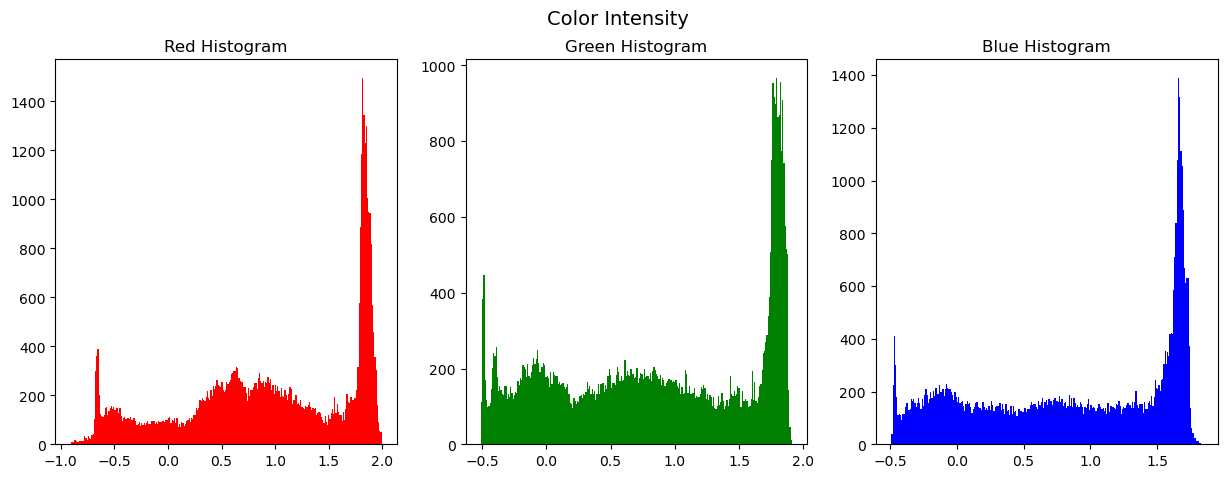

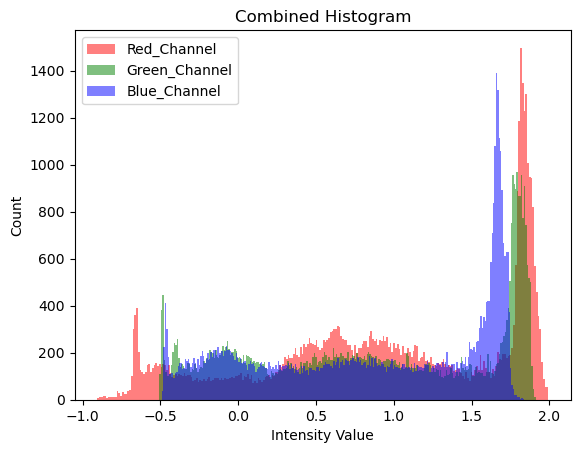

In [105]:
# Test some Feature Extractions

# Create image extract instance
ie = ImageExtract(pp)

ie.display_color_intensity(ie.npimage)


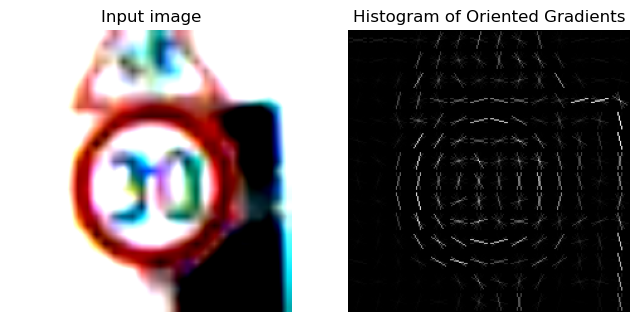

In [106]:
hog_image = ie.get_HOG(display=True)

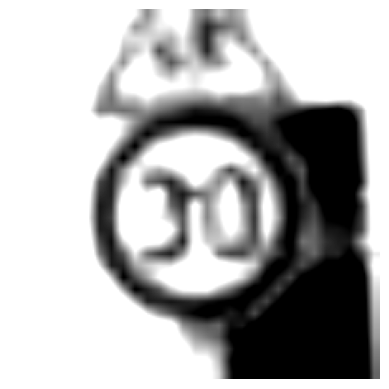

In [107]:
img = ie.image
img = ie.get_grayimage(img)
ie.display_image(img)


In [108]:
imgsq = tf.squeeze(img)
ed = EdgeDetector([imgsq], sigma=1.4, kernel_size=5, lowthreshold=0.09, highthreshold=0.17, weak_pixel=100)


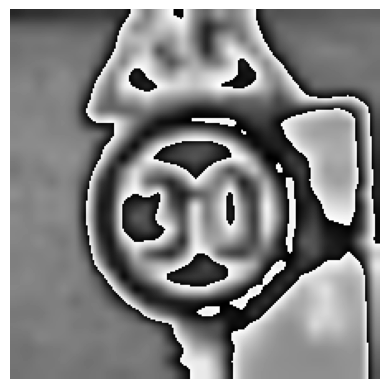

In [109]:
# Convolve and display the image
gaussian = ed.gaussian_kernel(size=5, sigma=1.5)
ie.display_image(convolve(imgsq, gaussian))

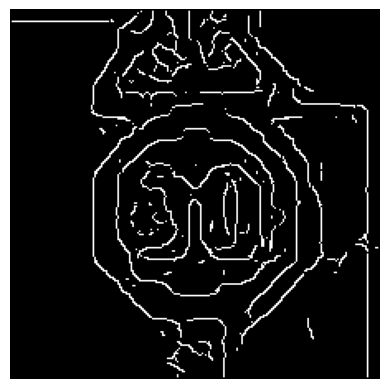

In [110]:
# Detect edges
ie.detect_edges(ed)

(224, 224)


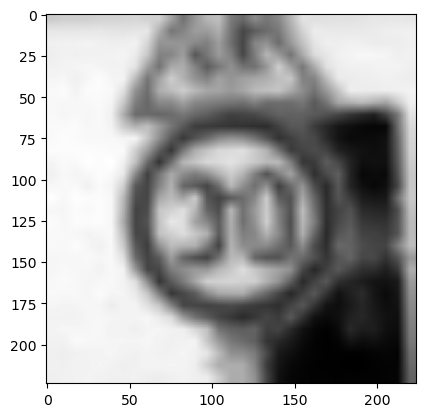

In [139]:
# Use same image to test template matching
imgtm = ed.imgs[0]
print(imgtm.shape)

# Show the image
plt.imshow(imgtm, cmap='gray')

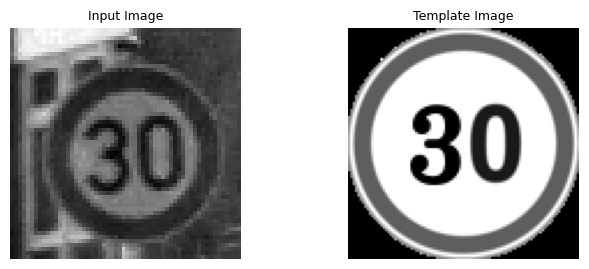

In [244]:
# Create instance of template matching
tm = TemplateMatching()

# Get a template for class = 1
template_name = dataset_path + dl.class_data[dl.class_data.ClassId==1].Path.item()
template = tm.open_image(template_name)

# Get sample image for same class
image_name = dataset_path + dl.train_meta.loc[[573]].Path.item()
image = tm.open_image(image_name)

# Show image and template
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Input Image', fontsize=9)
ax[1].imshow(template, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Template Image', fontsize=9)

plt.show()


100%|███████████████████████████████████████████████████████████████████████████████████| 58/58 [00:34<00:00,  1.70it/s]


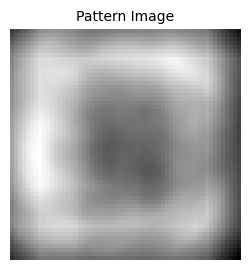

In [245]:
# Template matching (advacnced feature extraction)
imgtema = tm.match_template(img=image, template=template)

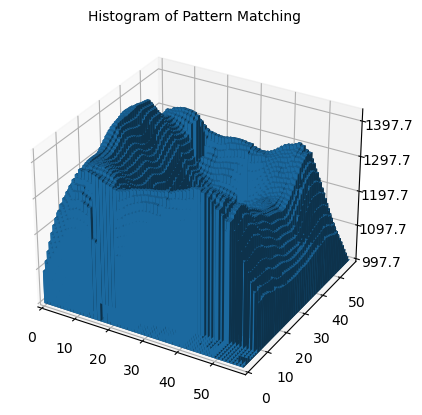

In [246]:
tm.plot3DHistograma(imgtema, [tm.minima, tm.maxima])